In [5]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
# Import important Libraries 
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score,classification_report
import warnings as warning

In [0]:
# Load Blogs Dataset
blogs_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/dataset/blogtext.csv')

In [8]:
# Print few lines from Dataset
blogs_df.head()

,id,gender,age,topic,sign,date,text
0,2059027,male,15,Student,Leo,"14,May,2004","Info has been found (+/- 100 pages,..."
1,2059027,male,15,Student,Leo,"13,May,2004",These are the team members: Drewe...
2,2059027,male,15,Student,Leo,"12,May,2004",In het kader van kernfusie op aarde...
3,2059027,male,15,Student,Leo,"12,May,2004",testing!!! testing!!!
4,3581210,male,33,InvestmentBanking,Aquarius,"11,June,2004",Thanks to Yahoo!'s Toolbar I can ...


In [9]:
# Print some information from Dataset
blogs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 681284 entries, 0 to 681283
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      681284 non-null  int64 
 1   gender  681284 non-null  object
 2   age     681284 non-null  int64 
 3   topic   681284 non-null  object
 4   sign    681284 non-null  object
 5   date    681284 non-null  object
 6   text    681284 non-null  object
dtypes: int64(2), object(5)
memory usage: 36.4+ MB


In [10]:
# Some insights
print("1. There are around 681 thousand data points and 7 columns")
print("2. There are 4 labels, 'gender', 'age', 'topic', 'sign'")
print("3. Data is huge so, we may need to work only on a subset of original dataset")

1. There are around 681 thousand data points and 7 columns
2. There are 4 labels, 'gender', 'age', 'topic', 'sign'
3. Data is huge so, we may need to work only on a subset of original dataset


In [11]:
# Let's see if there are any missing values
blogs_df.isna().sum()

id        0
gender    0
age       0
topic     0
sign      0
date      0
text      0
dtype: int64

In [12]:
print("We can see there are no missing values")

We can see there are no missing values


### Let's do some descriptive analysis on Dataset, 'text' column

In [0]:
# Let's drop duplicate entries from 'text' column
blogs_df.drop_duplicates(subset='text', inplace=True)

In [14]:
# Let's check new shape
blogs_df.shape

(611652, 7)

In [15]:
# Insight
print("We can see that many duplicate entries have been removed now")

We can see that many duplicate entries have been removed now


In [0]:
# Length of Strings in text Column 
text_length = blogs_df.text.str.len()

In [17]:
text_length.describe()

count    611652.000000
mean       1163.233872
std        2419.298950
min           4.000000
25%         250.000000
50%         676.000000
75%        1459.000000
max      790123.000000
Name: text, dtype: float64

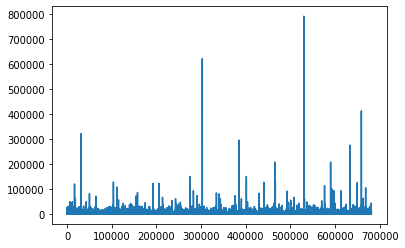

In [18]:
# Let's draw a plot on same to check the distribution of 'text' column
text_length.plot()

In [19]:
# Insights
print("1. We can see that there are some strings which is of very small length and some are very high")
print("2. There is possibility of Outliers in terms of srting length")

1. We can see that there are some strings which is of very small length and some are very high
2. There is possibility of Outliers in terms of srting length


In [0]:
# Let's handle very large and very small length strings in 'text' column
blogs_df_temp = blogs_df.loc[(text_length > 10) & (text_length < 15000)]

In [21]:
# Print shape of new dataset
blogs_df_temp.shape

(610698, 7)

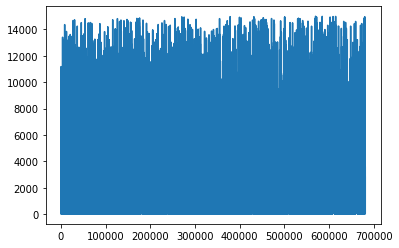

In [22]:
# Check the distribution of 'text' column in new dataset
blogs_df_temp.text.str.len().plot()

In [24]:
# Let's filter out bloggers who are very frequent (more than 50 for say) to remove bias from dataset
id_count = blogs_df_temp.groupby("id")["id"].transform("count")
blogs_df_temp = blogs_df_temp.loc[id_count < 10]
blogs_df_temp.shape

(42739, 7)

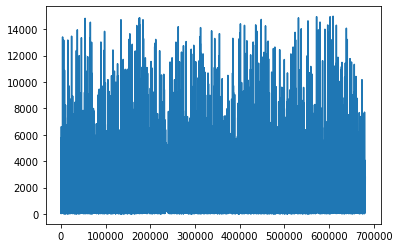

In [25]:
# Check the distribution of 'text' column in new dataset
blogs_df_temp.text.str.len().plot()

In [0]:
# Let's drop 'id' and 'date' columns as they will not add any value to our model
blogs_df_temp.drop(['id', 'date'], axis=1, inplace=True)

In [27]:
blogs_df_temp.head()

,gender,age,topic,sign,text
0,male,15,Student,Leo,"Info has been found (+/- 100 pages,..."
1,male,15,Student,Leo,These are the team members: Drewe...
3,male,15,Student,Leo,testing!!! testing!!!
95,female,25,indUnk,Capricorn,"urlLink im new to this, ..."
96,female,25,indUnk,Capricorn,Election time has rolled aro...


### Pre-Process the 'text' column

In [0]:
# Remove unwanted characters and keep only aphanumeric characters only along with spaces
import re

blogs_df_temp['text'] = blogs_df_temp['text'].apply(lambda x: re.sub('[^0-9a-zA-Z\s]', '', x))

In [0]:
# Convert text to lowercase
blogs_df_temp['text'] = blogs_df_temp['text'].apply(lambda x: x.lower())

In [0]:
# Strip all the text in the dataset to remove any extra spaces
blogs_df_temp['text'] = blogs_df_temp['text'].apply(lambda x: x.strip())

In [31]:
# import nltk library to deal with stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('punkt')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [0]:
# Method to remove Stop-words from a dataframe
def remove_stopwords(blog_df):
    stop_words = stopwords.words('english')
    clean_words = []
    for text in blog_df:
        text_tokens = word_tokenize(text)
        tokens_without_sw = [word for word in text_tokens if not word in stop_words]
        clean_words.append(' '.join(tokens_without_sw))
    return clean_words

In [0]:
blogs_df_temp['text'] = remove_stopwords(blogs_df_temp.text)

In [0]:
# Creating Bag of Words For 'text' column
#blogs_df_temp['bag_of_words'] = ''
#words = ''
#for index, row in blogs_df_temp.iterrows():
 #   words = words + ' '.join(row['text'])
  #  row['bag_of_words'] = words

In [35]:
blogs_df_temp.head(5)

,gender,age,topic,sign,text
0,male,15,Student,Leo,info found 100 pages 45 mb pdf files wait unti...
1,male,15,Student,Leo,team members drewes van der laag urllink mail ...
3,male,15,Student,Leo,testing testing
95,female,25,indUnk,Capricorn,urllink im new tell god create links column
96,female,25,indUnk,Capricorn,election time rolled around everyone spitting ...


In [36]:
# As we want to make this into a multi-label classification problem, 
# Let's merge all the label columns together, so that we have all the labels together for a particular sentence
# Label columns to merge: “gender”, “age”, “topic”, “sign”
blog_df_final = blogs_df_temp[['text']]
blog_df_final['lable'] = blogs_df_temp.gender + ',' + blogs_df_temp.age.astype(str) + ',' + blogs_df_temp.topic + ',' + blogs_df_temp.sign
blog_df_final.head()

,text,lable
0,info found 100 pages 45 mb pdf files wait unti...,"male,15,Student,Leo"
1,team members drewes van der laag urllink mail ...,"male,15,Student,Leo"
3,testing testing,"male,15,Student,Leo"
95,urllink im new tell god create links column,"female,25,indUnk,Capricorn"
96,election time rolled around everyone spitting ...,"female,25,indUnk,Capricorn"


### Separate features and labels, and split the data into training and testing

In [0]:
feature = blog_df_final['text']
label = blog_df_final['lable']

X_train, X_test, y_train, y_test = train_test_split(feature, label, test_size=0.25, random_state=7)

In [38]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(32054,)
(10685,)
(32054,)
(10685,)


### Vectorize the features

In [0]:
# Vectorization using Count Vectorizer
vectorizer = CountVectorizer(ngram_range=(1,2))

X_train_dtm = vectorizer.fit_transform(X_train)

X_test_dtm = vectorizer.transform(X_test)

In [40]:
# Check the shape of DTM
print(X_train_dtm.shape)
print(X_test_dtm.shape)

(32054, 2792999)
(10685, 2792999)


In [41]:
# Create a dictionary to get the count of every label
column_list = ['gender', 'age', 'topic', 'sign']
dictionary = dict()
for column in column_list:
    dictionary.update(dict(blogs_df_temp[column].value_counts()))
dictionary

{13: 1988,
 14: 3278,
 15: 3989,
 16: 4774,
 17: 5440,
 23: 4082,
 24: 4163,
 25: 3333,
 26: 2631,
 27: 2661,
 33: 918,
 34: 845,
 35: 736,
 36: 519,
 37: 512,
 38: 385,
 39: 288,
 40: 328,
 41: 346,
 42: 342,
 43: 225,
 44: 284,
 45: 212,
 46: 151,
 47: 143,
 48: 166,
 'Accounting': 222,
 'Advertising': 300,
 'Agriculture': 58,
 'Aquarius': 3254,
 'Architecture': 133,
 'Aries': 3333,
 'Arts': 1467,
 'Automotive': 146,
 'Banking': 232,
 'Biotech': 109,
 'BusinessServices': 353,
 'Cancer': 3761,
 'Capricorn': 3256,
 'Chemicals': 129,
 'Communications-Media': 859,
 'Construction': 104,
 'Consulting': 477,
 'Education': 2081,
 'Engineering': 567,
 'Environment': 65,
 'Fashion': 303,
 'Gemini': 3478,
 'Government': 541,
 'HumanResources': 225,
 'Internet': 770,
 'InvestmentBanking': 80,
 'Law': 404,
 'LawEnforcement-Security': 92,
 'Leo': 3493,
 'Libra': 3736,
 'Manufacturing': 183,
 'Maritime': 34,
 'Marketing': 421,
 'Military': 255,
 'Museums-Libraries': 118,
 'Non-Profit': 855,
 'Pisce

In [0]:
# Transform the labels
labelTransformer = MultiLabelBinarizer()
y_train_lab = labelTransformer.fit_transform(y_train)
y_test_lab = labelTransformer.transform(y_test)

In [0]:
# Choose a classifier
model_log = LogisticRegression(solver='lbfgs', class_weight='balanced')
clf = OneVsRestClassifier(model_log)

In [52]:
# Training Model
clf.fit(X_train_dtm[0:2000], y_train_lab[0:2000])

OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight='balanced',
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False),
                    n_jobs=None)

In [53]:
# Precited Label
y_pred = clf.predict(X_test_dtm[0:2000])

# Print Accuracy score and Classification report
print("Train Accuracy: {0}".format(accuracy_score(y_train_lab[0:2000],y_pred)))
print("Test Accuracy: {0}".format(accuracy_score(y_test_lab[0:2000],y_pred)))
print(classification_report(y_test_lab[0:2000],y_pred))

Train Accuracy: 0.0
Test Accuracy: 0.0005
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2000
           1       0.00      0.00      0.00        93
           2       0.00      0.00      0.00        14
           3       0.75      0.58      0.66       905
           4       0.56      0.37      0.44       821
           5       0.20      0.06      0.09       468
           6       0.30      0.07      0.12       486
           7       0.25      0.05      0.08       399
           8       0.22      0.05      0.08       387
           9       0.27      0.08      0.12       419
          10       0.00      0.00      0.00        26
          11       0.00      0.00      0.00        11
          12       0.18      0.03      0.05       405
          13       0.00      0.00      0.00        32
          14       0.26      0.06      0.09       369
          15       0.00      0.00      0.00       124
          16       0.00      0.00      

In [54]:
# Print true label and predicted label 
indeces = [20, 40, 80, 120, 160]
for index in indeces:
    y_pred = clf.predict(X_test_dtm[index])
    print("True Level: {0}".format(y_test_lab[index]))
    print("Predicted Level: {0}".format(y_pred))

True Level: [1 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 1 0 1 1
 1 0 1 1 1 1 1 0 1 0 0 0 0 0 1]
Predicted Level: [[1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 1 0
  0 1 0 1 1 1 0 0 0 1 1 1 1 0 0 0]]
True Level: [1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 1 1 0 1 0
 1 1 1 1 1 1 0 0 1 0 0 0 0 0 0]
Predicted Level: [[1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0
  0 1 0 1 1 1 0 0 0 1 0 1 1 0 0 0]]
True Level: [1 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0
 1 0 1 1 0 0 0 1 1 1 1 1 0 0 0]
Predicted Level: [[1 0 0 1 1 0 0 1 1 1 0 0 1 0 1 0 1 1 0 0 1 0 0 0 0 0 0 1 0 1 1 0 1 1 1 0
  0 1 1 1 1 0 0 0 1 1 1 1 1 0 0 0]]
True Level: [1 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 1 1 0
 1 0 1 1 0 0 0 0 1 1 1 1 0 0 0]
Predicted Level: [[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0
  0 1 0 1 1 1 0 0 0 1 0 0 0 0 0 0]]
True Level: [1 1

In [57]:
# Insights
print("1. So, it looks like Model couldn't judge the sentiments very accurately.")
print("2. This demonstrates one of the biggest challenges in sentiment analysis - understanding human semantics.")
print("3. Although, we tried to deal with biasness in the data but seems it is not enough.")
print("4. We need to do more data processing before we feed them to the model to get better accuracy")

1. So, it looks like Model couldn't judge the sentiments very accurately.
2. This demonstrates one of the biggest challenges in sentiment analysis - understanding human semantics.
3. Although, we tried to deal with biasness in the data but seems it is not enough.
4. We need to do more data processing before we feed them to the model to get better accuracy
